# Proyek Klasifikasi Gambar: [English Premier League Logo]
- **Nama:** Dimas Arya Nurhakim
- **Email:** dimas.yans338@gmail.com
- **ID Dicoding:** synnoer

## Import Semua Packages/Library yang Digunakan

In [49]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [50]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation

### Data Loading

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "train.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "alexteboul/english-premier-league-logo-detection-20k-images",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

<ipython-input-3-b4587840d44e>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                                             filepath          team_name  team
0  ../input/english-premier-league-logo-detection...  manchester-united    12
1  ../input/english-premier-league-logo-detection...  manchester-united    12
2  ../input/english-premier-league-logo-detection...  manchester-united    12
3  ../input/english-premier-league-logo-detection...  manchester-united    12
4  ../input/english-premier-league-logo-detection...  manchester-united    12


### Data Preprocessing

#### Split Dataset

In [4]:
df['filepath'] = df['filepath'].str.replace(
    '../input/english-premier-league-logo-detection-20k-images/',
    "/kaggle/input/english-premier-league-logo-detection-20k-images/"
)

In [5]:
def extract_image(filepath):
    img = cv2.imread(filepath)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading image at {filepath}")
    return img

df['image'] = df['filepath'].apply(extract_image)

In [6]:
df['image'].apply(lambda x: x.shape).value_counts()

,count
image,
"(140, 140, 3)",17015
"(112, 112, 3)",2985


In [7]:
df['image'] = df['image'].apply(lambda x: cv2.resize(x, (140,140)))
df['image'].apply(lambda x: x.shape).value_counts()

,count
image,
"(140, 140, 3)",20000


In [8]:
train_size = 1 - 0.1 - 0.1

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['team'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['team'], random_state=42)

train_df['team'].value_counts()

,count
team,
16,800
15,800
11,800
9,800
10,800
6,800
8,800
0,800
3,800


In [9]:
X_full_train = np.array(train_df['image'].tolist())
y_full_train =  pd.get_dummies(train_df['team_name']).values
X_test = np.array(test_df['image'].tolist())
y_test = pd.get_dummies(test_df['team_name']).values

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train,
    y_full_train,
    test_size=0.2,
    random_state=42
)

## Modelling

In [11]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 140, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(df['team'].nunique(), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5747 - loss: 11.3882 - val_accuracy: 0.9797 - val_loss: 0.0828
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9512 - loss: 0.1550 - val_accuracy: 0.9844 - val_loss: 0.0620
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9660 - loss: 0.1008 - val_accuracy: 0.9966 - val_loss: 0.0194
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9675 - loss: 0.1176 - val_accuracy: 0.9894 - val_loss: 0.0471
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9805 - loss: 0.0783 - val_accuracy: 0.9947 - val_loss: 0.0290
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9894 - loss: 0.0387 - val_accuracy: 0.9912 - val_loss: 0.0382


## Evaluasi dan Visualisasi

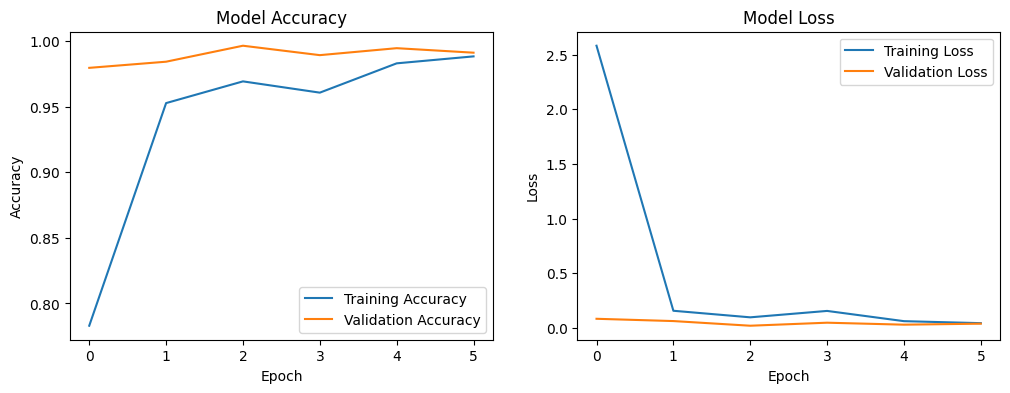

In [16]:
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [51]:
# SavedModel
model.export('model_saved')

# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# TFJS
tfjs.converters.save_keras_model(model, tfjs_target_dir)

Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 140, 140, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  137719753720272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753721040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753723920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753722192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753723344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753724688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753720464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753725072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753725456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137719753726992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [72]:
with open('label.txt', 'w') as f:
    for team_name in df['team_name'].unique():
        f.write(f"{team_name}\n")

In [73]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (140, 140))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [74]:
def classify_image(model, image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    predicted_team = df['team_name'].iloc[predicted_class_index]

    return predicted_class_index, predicted_team, confidence

In [75]:
image_path = 'MU.png'

In [76]:
class_index, team_name, confidence = classify_image(model, image_path)

print(f'Predicted class index: {class_index}')
print(f'Predicted team: {team_name}')
print(f'Confidence: {confidence:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class index: 11
Predicted team: manchester-united
Confidence: 0.0704


In [77]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def classify_image_tflite(interpreter, image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], processed_image)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]

    # Map the index to the team name
    predicted_team = df['team_name'].iloc[predicted_class_index]

    return predicted_class_index, predicted_team, confidence

In [78]:
tflite_class_index, tflite_team_name, tflite_confidence = classify_image_tflite(interpreter, image_path)

print("TFLite Inference:")
print(f'Predicted class index: {tflite_class_index}')
print(f'Predicted team: {tflite_team_name}')
print(f'Confidence: {tflite_confidence:.4f}')

TFLite Inference:
Predicted class index: 11
Predicted team: manchester-united
Confidence: 0.0704
